# TP1 : Linear regression

The purpose of this work is to implement least square linear regression to medical data. The problem is based on an example described in the book by Hastie & Tibshirani (2009) pp. 3-4 & 49-63. Data come from a study published by Stamey et al. (1989). This study aims at the prediction of the level of prostate specific antigen, denoted by `lpsa` below, from the
results of clinical exams. These exams are carried out before a possible
prostatectomy.

The measurements are log cancer volume `lcavol`, log prostate 
weight `lweight`, age of the patient `age`, log of benign prostatic 
hyperplasia amount `lbph`, seminal vesicle invasion `svi`, log of capsular 
penetration `lcp`, Gleason score `gleason`, and percent of Gleason scores 4 or 
5 `pgg45`. The variables `svi` and `gleason` are categorical, others are
quantitative. There are `p=8` entries.
The work is decomposed in the following tasks:

* read and format the data : extraction of the training and test sets,
* apply least square regression method to predict `lpsa` from the entries,
* study the estimated error on the test set (validation),
* identify the most significant entries by using a rejection test,
* apply regularized least square regression method (ridge regression),
* search for an optimal regularization parameter thanks to
cross-validation.

In [221]:
import csv
# import os
from pylab import *
import numpy as np
from numpy import linalg as la

import pandas as pd
import seaborn as sns

## Read & Normalize data
Data are stored in ASCII format: 

* the first column enumerates the data from 1 à 97 (97 male subjects). 
* columns 2 to 9 contain the entries themselves. 
* column 10 contains target values. 
* column 11 contains label 1 for the training set, 
and 2 for the test set.

In [222]:
#%% To read data from spaced separated float numbers
# x, y = np.loadtxt(c, delimiter=',', usecols=(0, 2), unpack=True)

data_init = np.loadtxt('prostate_data_sansheader.txt')

data = data_init[:,1:]   # we get rid of the indices (1 to 97)

#%% Extraction of training/test sets
Itrain = np.nonzero(data[:,-1]==1)
data_train=data[Itrain]   # original data

Itest = np.nonzero(data[:,-1]==0)
data_test = data[Itest]   # original data

**Normalization of the data** *with respect to the mean and standard deviation of the training set*.

In [223]:
M_train = data_train
M_test = data_test 
moy = np.zeros((8,))
sigma = np.zeros((8,))

# With a FOR loop :
for k in range(8): # 8 columns of entries
    moy[k]=np.mean(data_train[:,k])
    sigma[k] = np.std(data_train[:,k], ddof=0)
    M_train[:,k] = (data_train[:,k]-moy[k])/sigma[k] # normalized: centered, variance 1
    M_test[:,k] = (data_test[:,k]-moy[k])/sigma[k]   # same normalization for test set

print(sigma)

[ 1.23328245  0.47303067  7.44601122  1.45269103  0.41684299  1.39024269
  0.70355366 29.08227243]


In [224]:
# Alternative WITHOUT FOR
normalize = lambda vec: (vec-np.mean(vec))/np.std(vec)    # inline function 
M_train = np.array( [ normalize(vec) for vec in data_train[:,0:8].T ] ).T  # iterate on vec direct / ARRAY not LIST
moy = np.array( [ np.mean(vec) for vec in data_train[:,0:8].T ] )
sigma = np.array( [ np.std(vec, ddof=0) for vec in data_train[:,0:8].T ] )

M_test = np.array([ (data_test[:,k]-moy[k])/sigma[k] for k in range(M_train.shape[1]) ] ).T

<span style="color:MidnightBlue">
Other scaling methods could also be used, depending on our data and the model that is going to be used:

Here, we implemented a standard scaling, but we could also normalize (x = (x -x_min)/(x_max - x_min)). However the latter doesn't keep the same data distribution, and may fail if we have outliers (even extreme outliers) in a column, and put all values in a smaller range than $[0, 1]$.
</span>

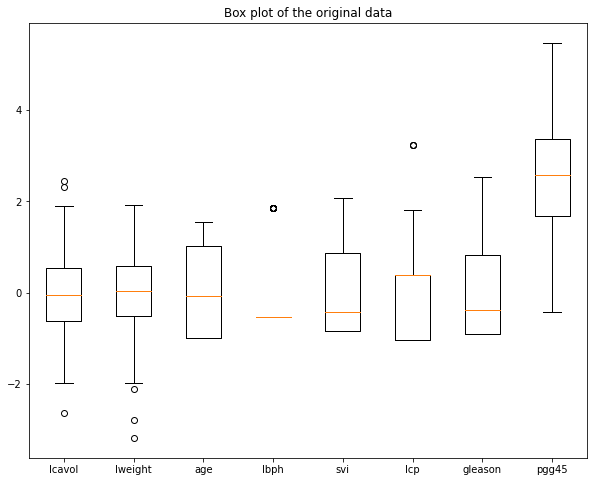

In [225]:
plt.figure(figsize=(10, 8)) 
plt.boxplot(data_train[:, 1:-1], labels=["lcavol", "lweight", "age", "lbph", "svi", "lcp", "gleason", "pgg45"])
plt.title("Box plot of the original data")
plt.show()

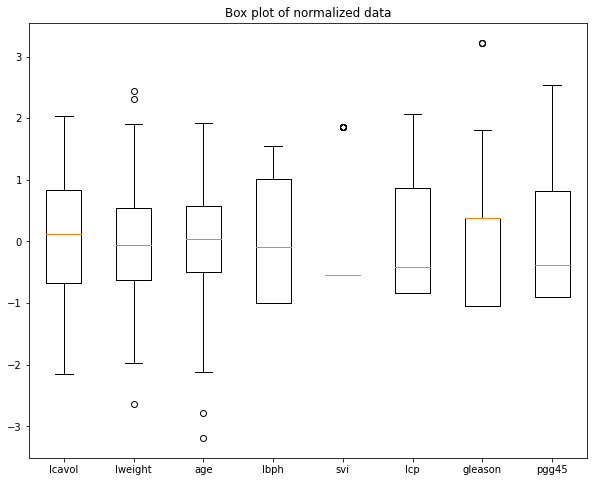

In [226]:
plt.figure(figsize=(10, 8)) 
plt.boxplot(M_train, labels=["lcavol", "lweight", "age", "lbph", "svi", "lcp", "gleason", "pgg45"])
plt.title("Box plot of normalized data")
plt.show()

<span style="color:MidnightBlue">
We noticed that the normalization solved some outlier problems, for lcavol and lcp features. The outliers at lweight, age and svi are still present. The rest of the feature don't show the the presence of any outlier.
</span>

<span style="color:MidnightBlue">
We can also note the distribution of certain features. For instance, lcp, pgg45 features are not symetrical, values are well scattered lower the median for lcp, than above it. svi and gleason are categorical, so it's correct to plot the histogram than the boxplot
</span>

Text(0.5, 1.0, 'Gleason distribution)')

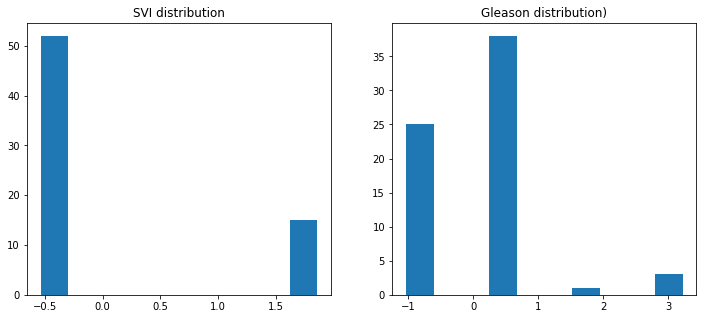

In [227]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(5)

ax1.hist(data_train[:,4])
ax1.set_title('SVI distribution')
ax2.hist(data_train[:,6])
ax2.set_title('Gleason distribution)')

<span style="color:MidnightBlue">
Both features are highly imbalanced, which explains the "outliers" we have in the boxplot.
</span>

# Part 1 : simple least square regression

## Preliminary questions
 
 * Compute the autocovariance matrix from the training set.
 * Observe carefully & Comment. What kind of information can you get ? 

Text(0.5, 1.0, 'covariance heatmap')

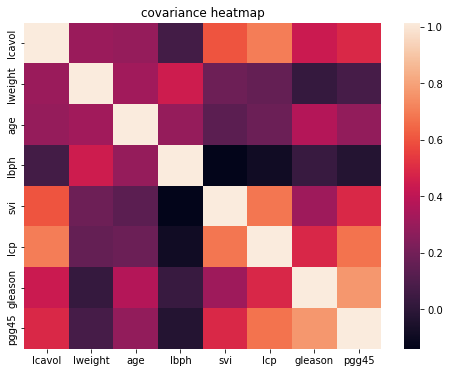

In [228]:
# Preliminary questions

# Calculate the covariance matrix without the target

y_train = data_train[:, 8]
y_test = data_test[:, 8]
feature_names = ["lcavol", "lweight", "age", "lbph", "svi", "lcp", "gleason", "pgg45"] # Features' names

cov_matrix = np.cov(M_train.T) # Covariance matrix

plt.figure(figsize=(8, 6))
ax = sns.heatmap(cov_matrix, xticklabels=feature_names, yticklabels=feature_names)
plt.title("covariance heatmap") # Add title to the plot

### Comments:

* "lbph" is independant of "lcavol", "svi", "lcp", "gleason", "pgg45".
* "pgg45" is usually related to older age, which is not shown in the matrix. However, the matrix illustrates the relationship between this feature and higher "gleason" scores. These two features could bring some redundancy to the problem and we may have to drop one of them. 
* the features "age" and "lweights" are not correlated with the rest.
* we can also note the correlation between "svi", "lcp" and "lcavol".


Text(0.5, 1.0, 'covariance heatmap with the target')

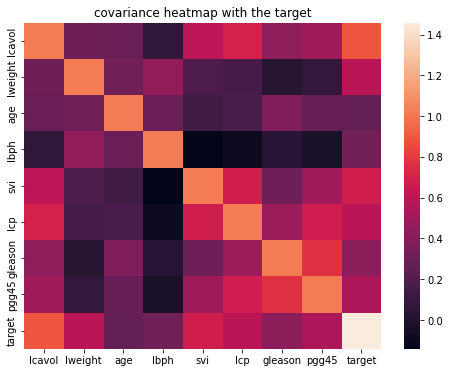

In [229]:
# Calculate the covariance matrix with the target

feature_names = ["lcavol", "lweight", "age", "lbph", "svi", "lcp", "gleason", "pgg45", "target"] # Features' names
cov_matrix = np.cov(M_train.T, y_train.T) # Covariance Matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cov_matrix, xticklabels=feature_names, yticklabels=feature_names)
plt.title("covariance heatmap with the target")

### Comments:

* The target here is not normalized, which is why we don't have the same value in the diagonal
* "Age", "lbph" and "gleason" are not correlated with the target (< 0.3).
* "pgg45" and "lcp" are correlated with the target (between 0.3 and 0.6).
* "lcavol", "svi" and "lweight" are very correlated with the target (> 0.6).
* The goal is to have features that are not correlated with eachother (independant), but correlated with the target and we can expect lcavol, lweight and svi to be of high importance in the problem.


Quelques rappels à propos de la notion de covariance : https://fr.wikipedia.org/wiki/Covariance

## Exercise 1 : least square regression 
 * Build the matrix of features `X_train` for the training set, the first column is made of ones.
 * Estimate the regression vector `beta_hat` (estimates= `X*beta_hat`)
 _Indication: you may either use the function `inv` or another more efficient way to compute $A^{-1}B$ (think of `A\B`)._ 
 * What is the value of the first coefficient `beta_hat[0]` ? What does it correspond to ?
 * Estimate the prediction error (quadratic error) from the test set.


*Indication: be careful of using `X_test` defined above, normalized w.r.t. the training data set. You can estimate this error by using:*

In [230]:
t_test = data_test[:,8]   # target column
N_test = data_test.shape[0]
X_test = np.concatenate((np.ones((N_test,1)), M_test[:,0:8]), axis=1) 
# don't forget the 1st column of ones and normalization !

In [231]:
# Exercise 1
N_train = data_train.shape[0]
X_train = np.concatenate((np.ones((N_train,1)), M_train[:,0:8]), axis=1)

pseudo_inverse = np.dot(np.linalg.inv(np.dot(X_train.T ,X_train)), X_train.T) 

beta_hat = np.dot(pseudo_inverse, y_train)

print("Regression vector, beta_hat: \n ", beta_hat) #beta_hat[0] = bias

Regression vector, beta_hat: 
  [ 2.45234509  0.71104059  0.29045029 -0.14148182  0.21041951  0.30730025
 -0.28684075 -0.02075686  0.27526843]


The first value in beta_hat corresponds to the bias i.e the mean of the target.

In [232]:
def estimate_target(X, beta):
    
    """Calculates the target
    
    Inputs:
        - X: the training set
        - beta: model parameters
    Output:
        - The predicted target """
    
    return np.dot(X, beta)

def error_quadratic(X, y, beta):
    """Defines the mean quadratic error given a set of parameters
    
    Inputs:
        - X: the training set
        - y: the real target data
        - beta: model parameters
    Output:
        - the quatratic error """
    
    N = X.shape[0]
    y_pred = estimate_target(X, beta)
    return (1/N)*np.dot((y - y_pred).T,(y - y_pred))

print("Train error: ", round(error_quadratic(X_train, y_train, beta_hat), 4))
print("Test error: ", round(error_quadratic(X_test, y_test, beta_hat), 4))

Train error:  0.4392
Test error:  0.5213


<span style="color:MidnightBlue"> The training error is smaller than on the test set, as expected (because we have more observations than features). In a highly-dimensional problem (i.e p>>1), it will be complicated to apply this algorithm, especially when calculating the inverse matrix of $X^TX$. In this case, we could reduce the dimensions by applying a PCA for example, or feature selection methods.</span>

## Rejection test, computation of Z-scores
Now we turn to the selection of the most significant entries so that our predictor be more robust. The essential idea is that our estimates will be more robust if only the most significant entries are taken into account. As a consequence, note that we will *reduce the dimension* of the problem from |p=8| to some smaller dimension. The present approach uses a statistical test to decide whether the regression coefficient corresponding to some entry is significantly non-zero. Then we can decide either to put non significant coefficients to zero, or to select the significant entries only and estimate the new reduced regression vector.

Let's assume that target values are noisy due to some white Gaussian
noise with variance $\sigma^2$ (see Hastie & Tibshirani p. 47). One can show that the estimated regression vector |beta_hat| is also Gaussian with variance

$$ var (\widehat{\beta}) = (X^TX)^{-1}\sigma^2.$$  

One can also show that the estimator of the variance (from the training set)

$$\widehat{\sigma^2}=\frac{1}{(N-p-1)}\sum (t_n-\widehat{t}_n)^2$$

obeys a Chi-2 distribution. As a consequence a Chi-square statistical test can be used to determine whether some coefficient $\beta_j$ is
significantly non-zero. To this aim, one defines the variables $z_j$
named Z-scores which in turn obey a Fisher law, also called
$t$-distribution, which are often used in statistics:

$$ z_j = \frac{\beta_j}{\widehat{\sigma}\sqrt{v_j}} $$

where $v_j$ is the $j$-th diagonal element of the matrix $(X^TX)^{-1}$.
For sake of simplicity, we will consider that the null hypothesis of
$\beta_j$ is rejected with probability 95% if the Z-score is greater than 2.

## Exercise 2
1. Compute the Z-scores and select the most significant entries.
2. Estimate the prediction error over the test set if only these significant 
entries are taken into account for regression by putting other regression 
coefficients to zero.
3. Estimate the new regression vector when only the significant features
are taken into account.
4. Compare to previous results (Exercise 1).

*Indication 1 : to sort a vector `Z` in descending order*
`val = np.sort(np.abs(Z))[-1:0:-1]`


*Indication 2 :* to extract the diagonal of a matrix,
`vXX = np.diag(inv(X.T.dot(X),k=0)`

In [233]:
# Exercise 2
N = y_train.shape[0]
P = X_train.shape[1] - 1
vXX = np.diag(inv(X_train.T.dot(X_train)), k=0) # using train to prevent any data leakage

# Determine the estimator of the variance
t_predicted = np.dot(X_train, beta_hat)
var_hat = np.sqrt((1/(N-P-1)) * np.dot((y_train - t_predicted).T,(y_train - t_predicted)))

# Calculate the z_scores list
z_scores = list(map(lambda x,y: round(x/(var_hat*np.sqrt(y)), 3), beta_hat[1:], vXX[1:]))
print("z_score (without bias): \n", z_scores)

# Get indexes z_score is greater than 2 
selected_index = np.argwhere(np.abs(z_scores)>2)
selected_index = np.squeeze(selected_index)
print(f"\nThe index of the selected features are {selected_index} which corresponds to these features")
for i in selected_index:
    print(f"   * {feature_names[i]}")

z_score (without bias): 
 [5.366, 2.751, -1.396, 2.056, 2.469, -1.867, -0.147, 1.738]

The index of the selected features are [0 1 3 4] which corresponds to these features
   * lcavol
   * lweight
   * lbph
   * svi


<span style="color:MidnightBlue">
We will select these columns and add the bias column to construct our new_X_test
</span>

In [234]:
new_beta_hat = [beta_hat[0]]+[x*int(i in selected_index) for i, x in enumerate(beta_hat[1:])]
print("new error with only selected entries: ", round(error_quadratic(X_test, y_test, new_beta_hat), 4))
print("old test error:", round(error_quadratic(X_test, y_test, beta_hat), 4))

new error with only selected entries:  0.4522
old test error: 0.5213


<span style="color:MidnightBlue">
This feature selection indeed improved the results, which suggested that the information in "age", "lcp", "gleason", "pgg45" wasn't helpful for the prediction model. Going back to the covariance matrix, we can see that "lcavol", "lweight" and "svi" had the heighest correlation with the target, and this confirms our findings.
It is however interesting to see that "lcp" and "pgg45" weren't selected, their Z-scores were close to 2 (1.9 and 1.77), and "gleason" as well.
</span>

<span style="color:MidnightBlue">
This test only looks at the features that were already important, and remove the others, it may not always work as the features may bring some information even if it is not significant and helps the model generalize better. That was the case when we added the feature "age", given how the studies show $[1, 2]$ the link between this feature and the probability to have a prostate:
</span>

In [235]:
new_beta_hat_exp = [beta_hat[0]]+[x*int(i in [0, 1, 2, 3, 4]) for i, x in enumerate(beta_hat[1:])]
print("new error with only selected entries: ", round(error_quadratic(X_test, y_test, new_beta_hat_exp), 4))
print("old test error:", round(error_quadratic(X_test, y_test, beta_hat), 4))

new error with only selected entries:  0.4064
old test error: 0.5213


[1] https://www.cancer-environnement.fr/fiches/cancers/cancer-de-la-prostate/#:~:text=L'%C3%A2ge%20est%20le%20principal,%C3%A0%20partir%20de%2080%20ans

[2] https://www.cancerresearchuk.org/health-professional/cancer-statistics/statistics-by-cancer-type/prostate-cancer/incidence

# Part 2: Regularized least squares
This part deals with regularized least square regression. We denote
by `beta_hat_reg` the resulting coefficients. This approach is an alternative to the selection based on statistical tests above. The idea is now to penalize large values of regression coefficients, *except for the bias*.

We use the result:

$$\hat{\beta} = (\lambda I_p + X_c^T X_c)^{-1} X_c^T t_c$$

where $X_c$ contains the normalized entries of the training data set with 
no column of ones (the bias should no be penalized and is processed). 
The targets `t_c` are therefore also centered, `t_c=t-mean(t)`.
 
First, we estimate the bias $t_0$ to center the targets which yields the coefficient $\beta_0$, that is `beta_hat_reg[0]` in Python.

*Remark : the bias is estimated as the empirical average of targets.
For tests, entries should be normalized with respect to the means and
variances of the training data set (see exercise 3.5 p. 95 in Hastie & Tibshirani). Then work on the vector of entries with no column of ones.*

## Exercise 3
1. Use _ridge regression_ for penalty `lambda = 25` to estimate the regression vector. 
2. Estimate the prediction error from the test set.
3. Compare the results (coefficients $\beta$, error...) to previous ones.
4. You may also compare these results to the result of best subset selection below:

`beta_best = [2.477 0.74 0.316 0 0 0 0 0 0]`.

*Indication : a simple way to obtain predictions for the test data set is the code below:*

In [236]:
t = data_train[:,8]   # column of targets
t0 = np.mean(t)

N_test = data_test.shape[0]
X_test = np.hstack((np.ones((N_test,1)), M_test[:,0:8]))  
# Here the 1st column of X_test is a column of ones.
# t_hat_reg = X_test.dot(beta_hat_reg)

In [237]:
# Exercise 3
lambda_v = 25
X_train_reg = M_train[:,0:8]
pseudo_inverse = np.dot(np.linalg.inv(lambda_v*np.eye(8) +np.dot(X_train_reg.T ,X_train_reg)), X_train_reg.T)
t0 = np.mean(y_train)
t_c = y_train - t0
beta_hat_reg = np.dot(pseudo_inverse, t_c)

beta_hat_reg = np.insert(beta_hat_reg, 0, t0) # Add beta[0]
print("beta before regularisation: ", beta_hat)
print("beta after regularisation: ", beta_hat_reg)

beta before regularisation:  [ 2.45234509  0.71104059  0.29045029 -0.14148182  0.21041951  0.30730025
 -0.28684075 -0.02075686  0.27526843]
beta after regularisation:  [ 2.45234509  0.4221092   0.24879171 -0.04226499  0.16575364  0.23091485
  0.01066329  0.04306017  0.13151316]


<span style="color:MidnightBlue">
The regularisation lessened the impact of the features, which may increase the training error but would help the generalization aspect (i.e better test error), this is illustrated in the cell below where we compare the previous training error with the new one:
</span>

In [238]:
print("\nPrevious train error: ", round(error_quadratic(X_train, y_train, beta_hat), 4))
print("\nNew train error: ", round(error_quadratic(X_train, y_train, beta_hat_reg), 4))


Previous train error:  0.4392

New train error:  0.5043


In [239]:
print("\nThe previous test error = 0.5213")
print("\nThe new test error using beta_hat reg : ", round(error_quadratic(X_test, y_test, beta_hat_reg),4))
beta_best = [2.477, 0.74, 0.316, 0, 0, 0, 0, 0, 0]
print("\nThe test error with the best beta hat: ", round(error_quadratic(X_test, y_test, beta_best), 4))


The previous test error = 0.5213

The new test error using beta_hat reg :  0.4939

The test error with the best beta hat:  0.4937


<span style="color:MidnightBlue">

The performance on the test set did improve, but was further improved when we silenced few features (using beta best).
</span>

<span style="color:MidnightBlue">
This indicates that some of the features weren't entirely beneficial to the decision process. However, going back to the rejection test, our error was even lower, and that could stem from the fact that in beta_best we may have silenced some important features, (like lbph and svi and age).
</span>

# Part 3: Cross-Validation 

## How to choose lambda from the training data set only ? 

The idea is to decompose the training set in 2 subsets: one subset for
linear regression (say 9/10 of the data), the other to estimate the prediction error (say 1/10 of the data).

We can repeat this operation 10 times over the 10 possible couples of
subsets to estimate the average prediction error. We will choose the
value of `lambda` which minimizes this error. The algorithm goes as
follows:

For the 10 cross-validation cases
    
    Extraction of test & training subsets `testset` & `trainset`
    
    For lambda in 0:40
        Estimate `beta_hat` from normalized `trainset` (mean=0, var=1)
        Estimate the error from  `testset`
    EndFor lambda

EndFor 10 cases

Compute the average error for each lambda

Choose `lambda` which minimizes the error 


## Exercise 4
* Use 6-fold cross-validation in the present study to optimize the choice of `lambda`. 
Try values of `lambda` ranging from 0 to 40 for instance (0:40).
* Plot the estimated error as a function of `lambda`.
* Propose a well chosen value of `lambda` and give the estimated corresponding
error on the test set.
* Comment on your results.

*Indication 1 : think of shuffling the dataset first.*

*Indication 2 : you can build 6 training and test subsets by using the code below*

In [240]:
lmax = 40 - 1
lambda_pos = arange(0,lmax+1) 

N_test = 10
m = np.zeros(8)
s = np.zeros(8)
X_traink = np.zeros((X_train.shape[0]-N_test,8))
X_testk = np.zeros((N_test,8))
erreur = np.zeros((6,lmax+1))
erreur_rel = np.zeros((6,lmax+1))

In [246]:
# Exercise 4 
import random
random.seed(10)
for p in range(6):   # loop on test subsets
    
    #we shuffle the data before splitting into batches
    shuffled_data = np.take(data_train,np.random.rand(data_train.shape[0]).argsort(),axis=0)
    
    # Extraction of trainset
    trainset = shuffled_data[hstack((arange(p*N_test),arange((p+1)*N_test,data_train.shape[0]))),0:9] 
    
    # Extraction of testset
    testset  = shuffled_data[arange(p*N_test,(p+1)*N_test),0:9] 
    
    #normalize the data
    M_train_cv = trainset
    M_test_cv = testset 
    moy = np.zeros((8,))
    sigma = np.zeros((8,))
    for k in range(8): 
        moy[k]=np.mean(trainset[:,k])
        sigma[k] = np.std(trainset[:,k], ddof=0)
        M_train_cv[:,k] = (trainset[:,k]-moy[k])/sigma[k] 
        M_test_cv[:,k] = (testset[:,k]-moy[k])/sigma[k]   # same normalization for test set  
        
    # y_train and y_test
    y_train = trainset[:, 8]
    y_test_cv = testset[:, 8]
        
    # iterate over different lambda
    for Lambda in range(0,40):
        # Add one column
        N_train = M_train_cv.shape[0]
        X_train = np.concatenate((np.ones((N_train,1)), M_train_cv[:,0:8]), axis=1)
        N_test_cv = M_test_cv.shape[0]
        X_test_cv = np.concatenate((np.ones((N_test,1)), M_test_cv[:,0:8]), axis=1)
        X_train_reg = M_train_cv[:,0:8]

        # Estimate beta_hat with/out regualization
        pseudo_inverse = np.dot(np.linalg.inv(Lambda*np.eye(8) +np.dot(X_train_reg.T ,X_train_reg)), X_train_reg.T)
        t0 = np.mean(y_train)
        t_c = y_train - t0
        beta_hat_reg = np.dot(pseudo_inverse, t_c)
        beta_hat_reg = np.insert(beta_hat_reg, 0, t0)
        
        # calculate the error
        erreur[p, Lambda] = error_quadratic(X_test_cv, y_test_cv, beta_hat_reg)
        

In [247]:
# Calculate the mean error
mean_error = np.mean(erreur, axis=0)
standard_deviation = np.std(mean_error)
standard_deviation

0.027001136320035465

Text(0.5, 1.0, 'Mean error w.r.t Lambda')

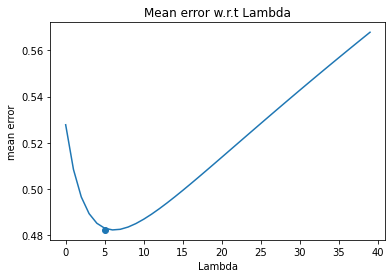

In [248]:
x_axes = np.arange(0, 40)
plt.plot(x_axes, mean_error)
x_min = list(mean_error[1:]).index(min(mean_error[1:]))
plt.scatter(y = min(mean_error[1:]), x=x_min)
plt.ylabel("mean error")
plt.xlabel("Lambda")
plt.title("Mean error w.r.t Lambda")

<span style="color:MidnightBlue">
We can see that the errors are scattered around a certain value, that changes within each execution. The data set changes because of the shuffling each time, so this suggests that the model is not robust enough as the order of the observations may have an impact on the results. 
The cross validation allows to have a better and more realistic perspective of the performance and the fact that the error doesn't change a lot (a standard deviation of 0.01) makes sure that the model is not biased.
</span>

<span style="color:MidnightBlue">
Given the outliers and imbalanced categorical features highlighted in the first part, we may counter some problems where the test set contains only the minority category (or the outliers). While we could use a stratified method for the split, we can not solve the outlier problem had it occured. We shuffle our data at each step so as to reduce the probability to have outlier problem (test fold containing a lot of outliers) in all the cross validation process.
</span>

In [249]:
print(f"The lambda that has minimum error is {list(mean_error[1:]).index(min(mean_error[1:]))} with an error = {round(min(mean_error[1:]), 4)} .") 

The lambda that has minimum error is 5 with an error = 0.4823 .


<span style="color:MidnightBlue">
After getting the Lambda value that minimizes the mean error from each cross validation step, we calculate the new beta hat regularized and test the model on the test set (from data_test). The mean quadratic error dropped to 0.4867 thanks to this experiment and it is the best result we have got so far, with all the features.
</span>

In [250]:
best_lambda = list(mean_error[1:]).index(min(mean_error[1:]))
pseudo_inverse = np.dot(np.linalg.inv(best_lambda*np.eye(8) +np.dot(X_train_reg.T ,X_train_reg)), X_train_reg.T)
t0 = np.mean(y_train)
t_c = y_train - t0
beta_hat_reg = np.dot(pseudo_inverse, t_c)
beta_hat_reg = np.insert(beta_hat_reg, 0, t0)
print(f"error with the best Lambda found: {round(error_quadratic(X_test, y_test, beta_hat_reg), 4)}")

error with the best Lambda found: 0.4867


<span style="color:MidnightBlue">
We started by scaling the data to put it in the right form, this part could have taken more steps for data set with missing values, more categorical features which could be one hot encoded. In this case, the model needed a data scaling so that some features don't get a high importance only because they contained higher values. In other models, like tree models (Decision trees, random forest, Extreme Gradient Boosting) this part could then be ommitted. 
</span>

<span style="color:MidnightBlue">
We took a look at the covariance matrix to predict the importance of the features, and those that we can remove if they are highly correlated with other features as they bring no new information. The data distribution plots gave us an overview of how each feature look like.
</span>

<span style="color:MidnightBlue">
In this problem, the parameters to find are stored in the beta vector, we first implement our model with all the features, then we reduced the dimensionality by removing those that weren't significantly non-zero, thus not as relevant to the decision as the others but it seems that even these features brought information even if small. In order to improve our generalization power, we add a constant Lambda that acts like a penalty and with a grid search cross validation with 6 folds and 41 values of Lambda, we were able to fine tune our model and retest it.
</span>

<span style="color:MidnightBlue">
Further work could be implemented in the data exploration to understand more the behavior of the model, as well as the feature selection method. If we try to perturb the data in a certain feature and fit the model on it, if the prediction is not that different from the original one, can we assume that the feature is not important? 
</span>